## **Implement CNN Algorithm for Classification**
**Dataset from BlackBoard:** Facial Emotion Recognition dataset

**File:** facial-emotion-recognition.zip (432.768 MB)

### **ToDo**
- Hyperparameter tuning
- Used proper loss/metrics standard in image classification, from sklearm.metrics
- Comparability: use same imported metric on all algorithms
- Explain model: google/vit-base-patch16-224-in21k
- Here we interpret term advanced according to lecture slides, which focus on knowledge transfer.
- In modern image classification goes without required pre-processing, thus skipped here. Traditional models do require manual crafted feature enginnering, while one of the key properties of ANN-based, feature engineering is inherent within the model as input data is transformed between hidden layers.
- Explain the code
- He param init became critical
- There are many base models to select from, here we selected visual transformer (ViT) as these are considered SOTA.
- https://pytorch.org/vision/0.18/models/generated/torchvision.models.resnet50.html
- VGG19 was trained from scratch, and required 100 times larger learning rate, than finetuning the ViT from google



@misc{wu2020visual,
      title={Visual Transformers: Token-based Image Representation and Processing for Computer Vision}, 
      author={Bichen Wu and Chenfeng Xu and Xiaoliang Dai and Alvin Wan and Peizhao Zhang and Zhicheng Yan and Masayoshi Tomizuka and Joseph Gonzalez and Kurt Keutzer and Peter Vajda},
      year={2020},
      eprint={2006.03677},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}

In [1]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch import nn, optim
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
import time
import copy
import os
import torch.nn.functional as F
import torch.nn.init as init

---
## **VGG19 CNN**
---

In [5]:
# Define VGG19 architecture
class VGG19(nn.Module):
    def __init__(self, num_classes=6):  # Adjust num_classes for your dataset
        super(VGG19, self).__init__()
        
        # Convolutional layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 4096),  # The input size here (512*7*7) depends on the input image size (224x224)
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)  # Output layer with number of classes in your dataset
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)
        return x

def initialize_he_weights(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):  # Convolutional layers
            init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
            if module.bias is not None:
                init.zeros_(module.bias)
        elif isinstance(module, nn.Linear):  # Fully connected layers
            init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
            if module.bias is not None:
                init.zeros_(module.bias)

In [6]:
# Step 1: Define the path to your local dataset
dataset_path = "/cluster/work/thohau/IT3212/assignment_4/thomas/intel-image-classification/seg_train/seg_train/"  # Replace this with the actual path to your dataset
model_path_vgg19 = "/cluster/work/thohau/IT3212/assignment_4/thomas/models/vgg19_it3212_gr25.pth"

# Step 1: Load the full dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the expected input size for ViT
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet standard normalization
]))

# Ensure that we correctly detect the classes from the subfolders
class_names = full_dataset.classes  # List of class names (subfolder names under dataset_path)
print("Classes found in the dataset:")
for idx, class_name in enumerate(class_names):
    print(f"{idx}: {class_name}")

# Step 2: Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = len(full_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


# Step 4: Set up DataLoader for training and validation
BACTH_SIZE = 64
MAX_EPOCHS = 90
EARLY_STOP = 5
train_loader = DataLoader(train_dataset, batch_size=BACTH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BACTH_SIZE, shuffle=False)

# Step 5: Print the size of training and validation datasets
print(f"\nTraining dataset size: {len(train_dataset)} samples")
print(f"Validation dataset size: {len(val_dataset)} samples")

# Step 6: Print a few examples from the dataset to verify the structure
print("\nExample images and labels from the dataset:")
for i in range(5):
    image, label = full_dataset[i]  # Access the first 5 samples
    print(f"Image {i}: Label = {class_names[label]}")  # Print class name for label


# Load a custom VGG19 model from scratch
model = VGG19(num_classes=len(class_names))  # Adjust 'num_classes' based on your dataset
initialize_he_weights(model)
print(model)  # Optional: print the model architecture


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

# Define Loss function (CrossEntropyLoss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define Optimizer
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(
    model.parameters(),       # Parameters to optimize (model's weights)
    lr=0.001,                 # Learning rate
    betas=(0.9, 0.999),       # Beta values for moment estimates (default)
    eps=1e-7,                 # Small value to prevent division by zero (default)
    weight_decay=1e-4         # L2 regularization (optional)
)

# Learning rate scheduler (optional, helps with fine-tuning)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Variables to track loss and accuracy
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

print(f"-------- START - Train VGG19 on Intel Dataset -----------")
# Function to train the model with Early Stopping
def train_model(model,
                criterion,
                optimizer,
                num_epochs=10,
                patience=5,
                save_model=False, 
                model_save_path="best_model.pth"):
    start_time = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())  # Save the best model weights
    best_acc = 0.0
    best_loss = float('inf')  # Initialize best_loss as a very large number
    epoch_no_improvement = 0  # Count of consecutive epochs with no improvement
    
    for epoch in range(num_epochs):
        print(f'Epoch [{epoch}/{num_epochs - 1}]')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            dataloaders = train_loader if phase == 'train' else val_loader
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward Pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward Pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders.dataset)
            epoch_acc = running_corrects.double() / len(dataloaders.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save loss and accuracy in history lists
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())  # Convert to a scalar value
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())  # Convert to a scalar value

            # Early Stopping Logic: Check if validation loss improved
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                if epoch_loss < best_loss:
                    # If validation loss improved, reset the counter and save the model
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epoch_no_improvement = 0  # Reset the no-improvement counter
                else:
                    epoch_no_improvement += 1

                # Stop training if no improvement for 'patience' epochs
                if epoch_no_improvement >= patience:
                    print(f"Early stopping after {patience} epochs with no improvement.")
                    model.load_state_dict(best_model_wts)  # Restore best model
              
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # Load best model weights in case of early stopping
    model.load_state_dict(best_model_wts)
    
    # Save model if specified
    if save_model:
        print(f"Saving model to {model_save_path}")
        torch.save(model.state_dict(), model_save_path)

    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=MAX_EPOCHS, patience=EARLY_STOP, save_model=True, model_save_path=model_path_vgg19)

# Plot Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (VGG19)')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy', color='blue')
plt.plot(val_acc_history, label='Validation Accuracy', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (VGG19)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

Classes found in the dataset:
0: buildings
1: forest
2: glacier
3: mountain
4: sea
5: street

Training dataset size: 11227 samples
Validation dataset size: 2807 samples

Example images and labels from the dataset:
Image 0: Label = buildings
Image 1: Label = buildings
Image 2: Label = buildings
Image 3: Label = buildings
Image 4: Label = buildings
VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_si

KeyboardInterrupt: 

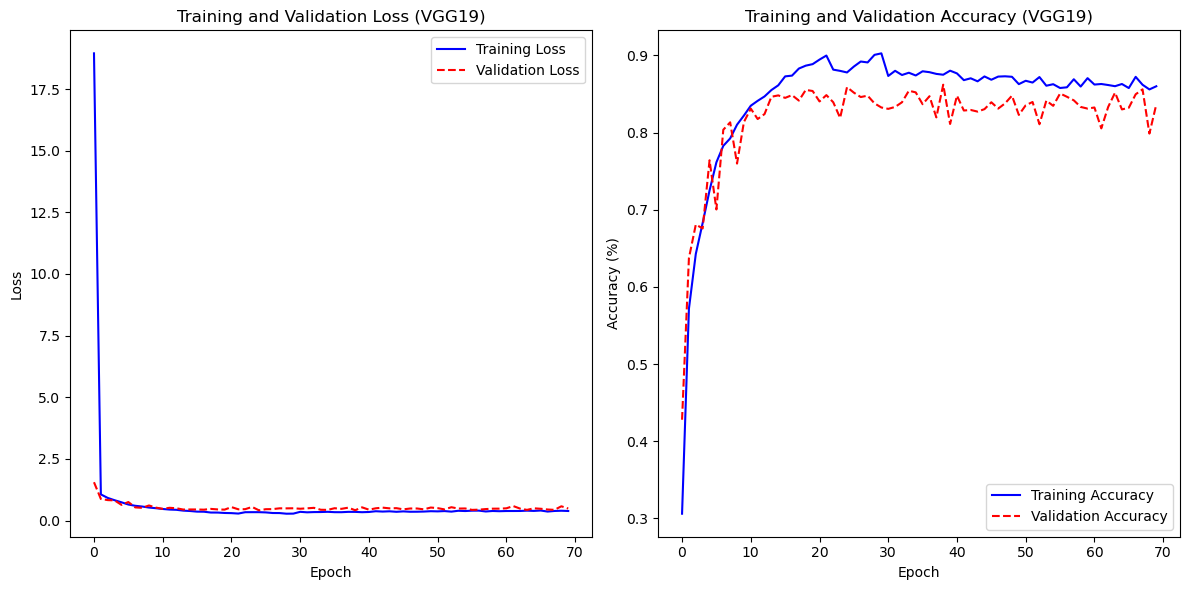

In [7]:
# Plot Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (VGG19)')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy', color='blue')
plt.plot(val_acc_history, label='Validation Accuracy', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (VGG19)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pretrained model (ResNet50)
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 6)  # Modify the final layer for 6 output classes

# Load the saved model state dictionary
model_path_rsnet = '/cluster/work/thohau/IT3212/assignment_4/thomas/models/resnet_it3212_gr25.pth'
state_dict = torch.load(model_path_rsnet, map_location=device)

# Load the state dict into the model
model.load_state_dict(state_dict, strict=False)  # Use strict=False to ignore the mismatch in fc layer

# Print size of the model in MB
model_size = os.path.getsize(model_path_rsnet) / (1024 * 1024)  # Convert bytes to MB
print(f"Model size: {model_size:.2f} MB")

# Count the number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")



# Load the test dataset (replace with your actual test dataset path)
test_dataset_path = dataset_path = "/cluster/work/thohau/IT3212/assignment_4/thomas/intel-image-classification/seg_test/seg_test/"  # Replace this with the actual path to your dataset

test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the expected input size for ResNet
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
]))

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print the size of the test dataset
print(f"Test dataset size: {len(test_dataset)} samples")

# Function to evaluate the model on the test set
def evaluate_model_on_test(model, test_loader):
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model = model.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Get predicted class labels

            running_corrects += torch.sum(preds == labels.data)

            predictions.extend(preds.cpu().numpy())  # Store predictions
            true_labels.extend(labels.cpu().numpy())  # Store true labels

    # Calculate accuracy
    accuracy = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {accuracy:.4f}')

    # Generate and print the classification report

    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=test_dataset.classes))
    
# Final evaluation on the test dataset
evaluate_model_on_test(model, test_loader)


def plot_random_images_with_predictions(model, test_dataset, num_images=6):
    # Ensure that we sample one image per class
    class_indices = {i: [] for i in range(len(test_dataset.classes))}
    
    # Collect image indices for each class
    for idx, (_, label) in enumerate(test_dataset):
        class_indices[label].append(idx)
    
    # Sample one image from each class
    sampled_indices = []
    for class_id in range(len(test_dataset.classes)):
        sampled_indices.append(random.choice(class_indices[class_id]))  # Randomly sample one image per class
    
    # Adjust the figure size to better fit the 3x2 layout
    plt.figure(figsize=(10, 12))  # Adjusted size for a 3x2 grid
    plt.suptitle('ResNet-50, Predicted vs Ground Truth')

    for i, idx in enumerate(sampled_indices):
        image, true_label = test_dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Get prediction
        with torch.no_grad():
            outputs = model(image)
            _, preds = torch.max(outputs, 1)
            pred_label = preds.item()
            confidence = torch.softmax(outputs, dim=1)[0, preds].item() * 100  # Confidence in percentage

        # Plot the image
        plt.subplot(3, 2, i + 1)
        plt.imshow(image.squeeze(0).cpu().permute(1, 2, 0))  # Remove batch dimension and permute to HWC
        plt.axis('off')

        # Get class names
        true_class = test_dataset.classes[true_label]
        pred_class = test_dataset.classes[pred_label]

        # Title with Ground Truth, Predicted Class, and Confidence
        plt.title(f"GT: {true_class}\nPred: {pred_class}\n{confidence:.2f}%")

    plt.tight_layout()
    plt.show()


# Plot random images with predictions (one from each category)
plot_random_images_with_predictions(model, test_dataset)

In [4]:
print(f"Memory allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Memory reserved: {torch.cuda.memory_reserved()} bytes")

# Perform memory cleanup
torch.cuda.empty_cache()

print(f"Memory allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Memory reserved: {torch.cuda.memory_reserved()} bytes")

Memory allocated: 2207553536 bytes
Memory reserved: 10066329600 bytes
Memory allocated: 2207553536 bytes
Memory reserved: 4181721088 bytes
